# My exercises on exploring a Birminham parking dataset

In [1]:
import pandas as pd
import numpy as np
import sklearn
import datetime

BIRMINGHAM_PARKING_DATASET_URL = 'https://raw.githubusercontent.com/reddyprasade/Machine-Learning-Problems-DataSets/master/Regression/Parking%20Birmingham.csv'

bir_csv = np.genfromtxt(BIRMINGHAM_PARKING_DATASET_URL,delimiter=',', dtype=str)
header, data = bir_csv[0,1:], bir_csv[1:,1:]

bir_dataframe = pd.DataFrame(
    data,
    columns=header,
).astype({
    'SystemCodeNumber': str,
    'Capacity': int,
    'Occupancy': int,
    'LastUpdated': 'datetime64[s]'
})
bir_dataframe.head()

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48


Grouping by the `SystemCodeNumber` to see how the occupancy rate varies by the parking lot.

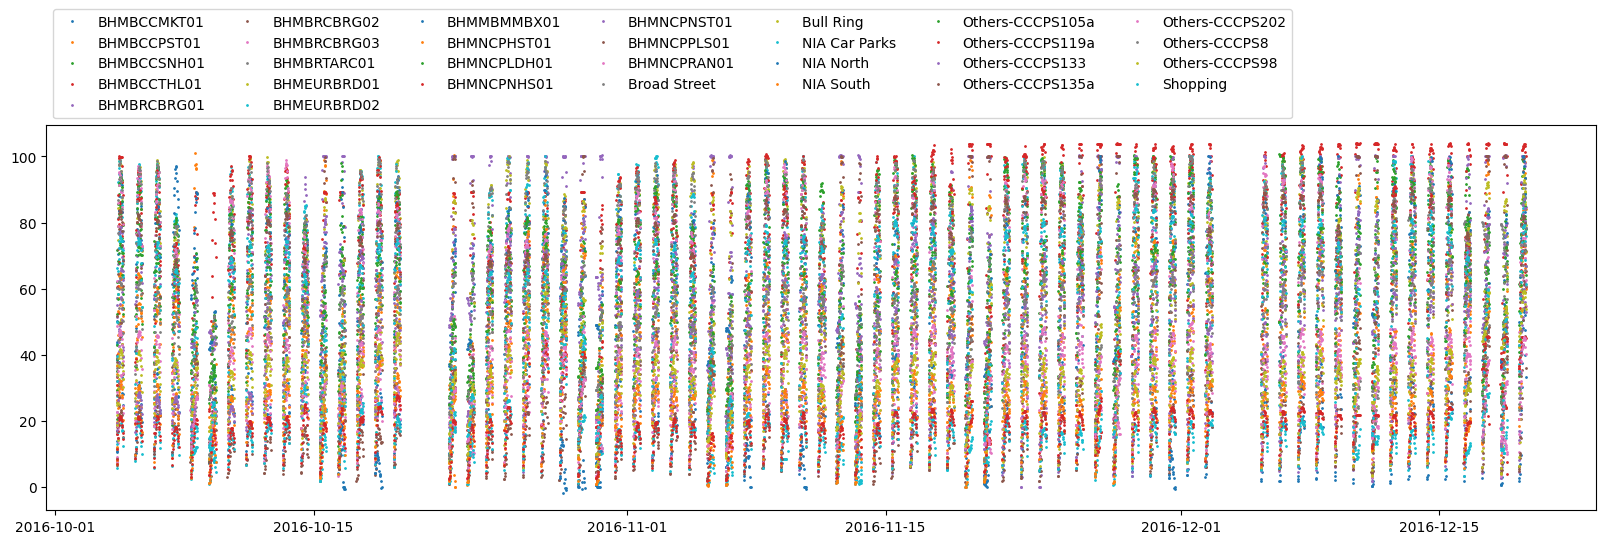

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.figure.dpi = 300

grouped_by_lots = bir_dataframe.groupby('SystemCodeNumber')
for group in grouped_by_lots.groups.keys():
    current_group_timeseries = grouped_by_lots.get_group(group)
    plt.plot(
        current_group_timeseries['LastUpdated'],
        (current_group_timeseries['Occupancy'] / current_group_timeseries['Capacity']) * 100,
        'o',
        markersize=1,
        label=current_group_timeseries['SystemCodeNumber'].values[0],
    )
plt.legend(
    loc=3,
    ncols=len(grouped_by_lots.groups.keys()) // 4,
    bbox_to_anchor=(0.0, 1.0)
)
plt.show()

It can be seen that there are gaps in the timeseries, where the occupancy drops significantly. This is likely due to the parking lot being closed at certain times or due to limited traffic in these areas. As we can see, finding these gaps from one timeseries will be sufficient for all of the other timeseries, as they all have the same gaps.

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48


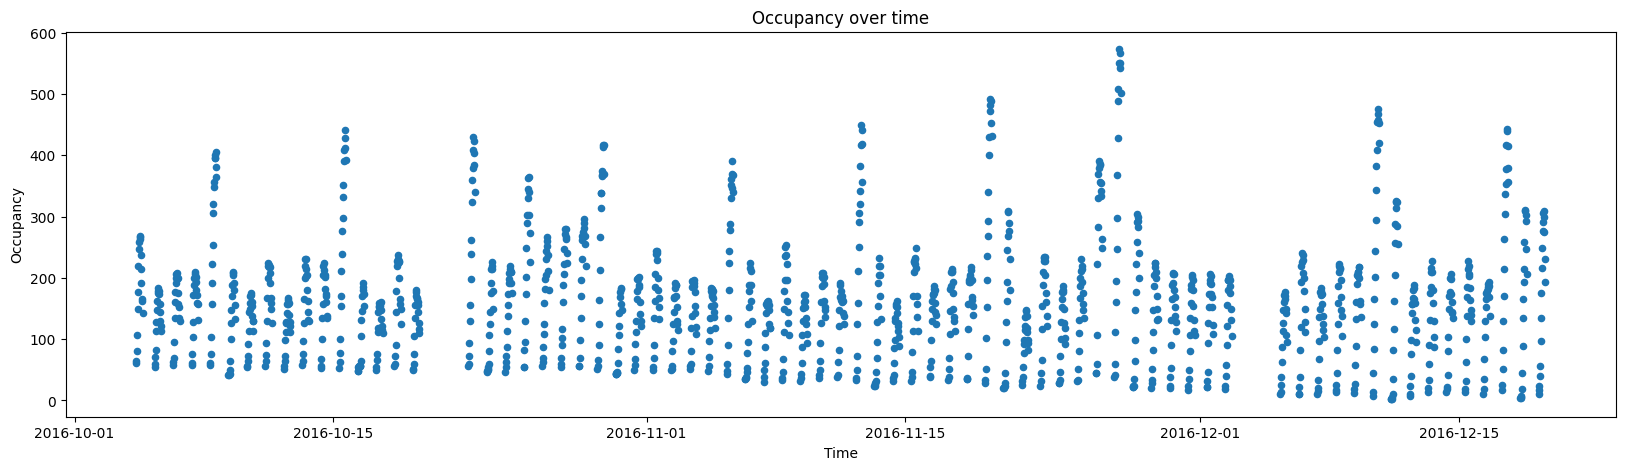

In [3]:
first_lot_data = grouped_by_lots.get_group(
    [*grouped_by_lots.groups.keys()][0]
)

first_lot_data.plot(
    x='LastUpdated',
    y='Occupancy',
    kind='scatter',
    figsize=(20,5),
    title='Occupancy over time',
    xlabel='Time',
    ylabel='Occupancy'
)
first_lot_data.head()

In [21]:
timestamps = pd.DataFrame(first_lot_data['LastUpdated'].values, columns=['Timestamp'])
timestamps['Difference'] = timestamps['Timestamp'].diff().fillna(pd.Timedelta(seconds=0)).apply(lambda x: x.total_seconds() / 3600)

WEEKDAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

gaps = []

for gap_end_index in timestamps[
    timestamps['Difference'] > 24
].index:
    gap_start_datetime = timestamps.loc[gap_end_index - 1]['Timestamp']
    gap_end_datetime = timestamps.loc[gap_end_index]['Timestamp']
    print(
        f"Gap between {gap_start_datetime} ({WEEKDAYS[gap_start_datetime.weekday()]}) and {gap_end_datetime} ({WEEKDAYS[gap_end_datetime.weekday()]})"
    )
    gaps.append((gap_start_datetime.timestamp(), gap_end_datetime.timestamp()))

Gap between 2016-10-19 16:25:03 (Wednesday) and 2016-10-22 07:59:45 (Saturday)
Gap between 2016-12-02 16:32:54 (Friday) and 2016-12-05 08:02:03 (Monday)


Having this information, we can divide each timeseries into three distinct datasets:

* before the first gap
* between the first and the second gap
* after the second gap

The largest dataset is the one between the first and the second gap, so we will train our model on this dataset. We will use the other two datasets to validate our model - the first one will be used to validate the model and the second one will be used to test the model.

In [22]:
import sklearn.preprocessing

one_hot_encoder = sklearn.preprocessing.OneHotEncoder()
one_hot_encoder.fit(
    bir_dataframe['SystemCodeNumber'].values.reshape(-1, 1)
)
lots_dummies = one_hot_encoder.transform(
    bir_dataframe['SystemCodeNumber'].values.reshape(-1, 1)
).toarray()

encoded_bir_dataframe = bir_dataframe.join(
    pd.DataFrame(
        lots_dummies,
        columns=bir_dataframe['SystemCodeNumber'].unique(),
    )
).drop(
    'SystemCodeNumber',
    axis=1
)

encoded_bir_dataframe['LastUpdated'] = encoded_bir_dataframe['LastUpdated'].apply(lambda x: x.timestamp())

print(encoded_bir_dataframe.head())

validation_data, training_data, test_data = encoded_bir_dataframe[
    encoded_bir_dataframe['LastUpdated'] < gaps[0][0]
], encoded_bir_dataframe[
    (encoded_bir_dataframe['LastUpdated'] > gaps[0][1]) & (encoded_bir_dataframe['LastUpdated'] < gaps[1][0])
], encoded_bir_dataframe[
    encoded_bir_dataframe['LastUpdated'] > gaps[1][1]
]


   Capacity  Occupancy   LastUpdated  BHMBCCMKT01  BHMBCCPST01  BHMBCCSNH01  \
0       577         61  1.475568e+09          1.0          0.0          0.0   
1       577         64  1.475570e+09          1.0          0.0          0.0   
2       577         80  1.475572e+09          1.0          0.0          0.0   
3       577        107  1.475574e+09          1.0          0.0          0.0   
4       577        150  1.475575e+09          1.0          0.0          0.0   

   BHMBCCTHL01  BHMBRCBRG01  BHMBRCBRG02  BHMBRCBRG03  ...  NIA North  \
0          0.0          0.0          0.0          0.0  ...        0.0   
1          0.0          0.0          0.0          0.0  ...        0.0   
2          0.0          0.0          0.0          0.0  ...        0.0   
3          0.0          0.0          0.0          0.0  ...        0.0   
4          0.0          0.0          0.0          0.0  ...        0.0   

   NIA South  Others-CCCPS105a  Others-CCCPS119a  Others-CCCPS133  \
0        0.0     

 Next, average daily occupancies will be calculated to see if there are any patterns in the data.

In [6]:
for group in grouped_by_lots.groups.keys():
    current_group_timeseries = grouped_by_lots.get_group(group).copy()
    current_group_timeseries['LastUpdatedDay'] = current_group_timeseries['LastUpdated'].dt.date
    current_group_timeseries['LastUpdatedTime'] = current_group_timeseries['LastUpdated'].dt.time
    current_group_timeseries.drop('LastUpdated', axis=1, inplace=True)
    current_group_timeseries['OccupancyPercentage'] = (current_group_timeseries['Occupancy'] / current_group_timeseries['Capacity']) * 100
    grouped_by_days = current_group_timeseries.groupby('LastUpdatedDay')
    aggregated_values = []
    for day in grouped_by_days.groups.keys():
        current_group_timeseries_day = grouped_by_days.get_group(day)
        aggregated_values.append(current_group_timeseries_day["OccupancyPercentage"].values)
    aggregated_df = pd.DataFrame(aggregated_values)